<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Fri Mar 15 10:23:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#1. Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} directory already exists.... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading pizza, steak and sushi data...')
  f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unziping pizza, steak and sushi data...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unziping pizza, steak and sushi data...


#2. Data prep and exploration

In [7]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in "data/pizza_steak_sushi".
There are 3 directories and 0 images in "data/pizza_steak_sushi/test".
There are 0 directories and 25 images in "data/pizza_steak_sushi/test/pizza".
There are 0 directories and 19 images in "data/pizza_steak_sushi/test/steak".
There are 0 directories and 31 images in "data/pizza_steak_sushi/test/sushi".
There are 3 directories and 0 images in "data/pizza_steak_sushi/train".
There are 0 directories and 78 images in "data/pizza_steak_sushi/train/pizza".
There are 0 directories and 75 images in "data/pizza_steak_sushi/train/steak".
There are 0 directories and 72 images in "data/pizza_steak_sushi/train/sushi".


In [9]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/train/sushi/2641778.jpg
sushi
Image height: 512 | image width: 512


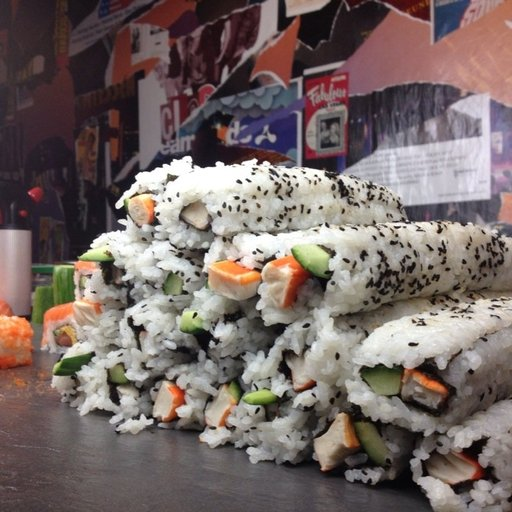

In [22]:
import random
from PIL import Image

random.seed(33)

image_path_list = list(image_path.glob('*/*/*.jpg'))


random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f'Image height: {img.height} | image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

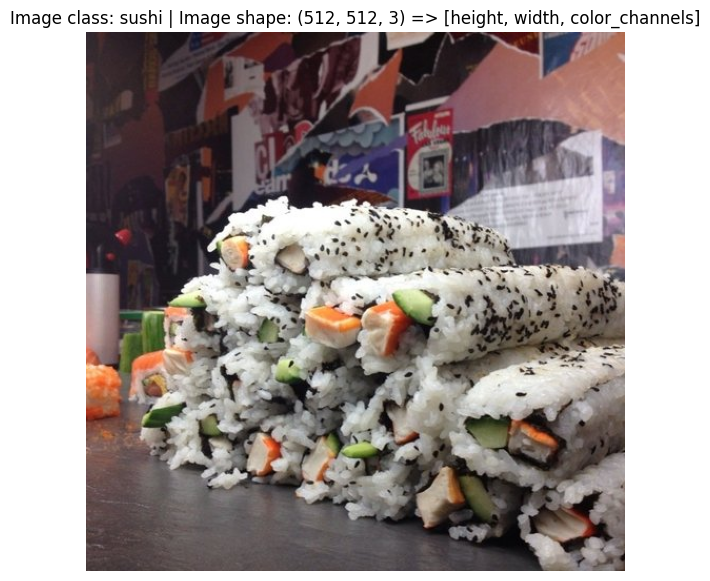

In [24]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} => [height, width, color_channels]')
plt.axis('off')

#3. Transform data

In [25]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [27]:
data_transform = transforms.Compose([
    #resize to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turrn image into a torch.Tensor
    transforms.ToTensor()
])

In [29]:
data_transform(img).shape

torch.Size([3, 64, 64])

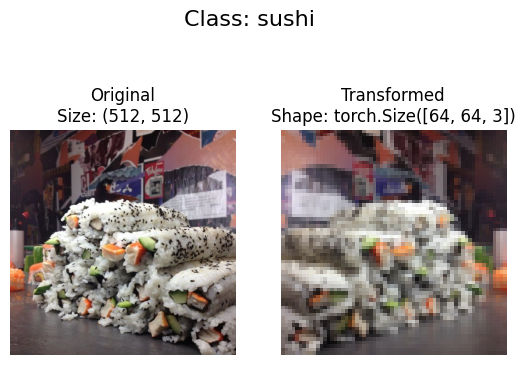

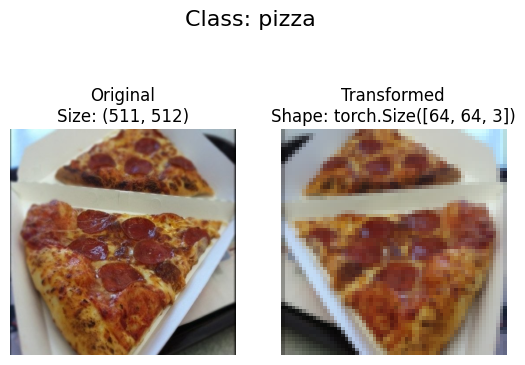

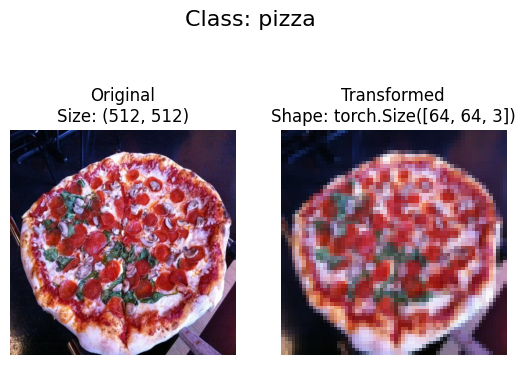

In [39]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax =plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis('off')

      transformed_image = transform(f).permute(dims=[1, 2, 0])
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                             transform=data_transform,
                             n=3,
                             seed=33)